In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec
import lightkurve as lk

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
search_result = lk.search_lightcurve('TIC 416538823')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,SPOC,120,416538823,0.0
1,TESS Sector 22,2020,SPOC,120,416538823,0.0
2,TESS Sector 49,2022,SPOC,20,416538823,0.0
3,TESS Sector 48,2022,SPOC,20,416538823,0.0
4,TESS Sector 49,2022,SPOC,120,416538823,0.0
5,TESS Sector 48,2022,SPOC,120,416538823,0.0
6,TESS Sector 75,2024,SPOC,20,416538823,0.0
7,TESS Sector 76,2024,SPOC,20,416538823,0.0
8,TESS Sector 76,2024,SPOC,120,416538823,0.0


0
1
4
5
8
9
[SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 15 2019   SPOC     120   416538823      0.0, SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 22 2020   SPOC     120   416538823      0.0, SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 49 2022   SPOC     120   416538823      0.0, SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s 

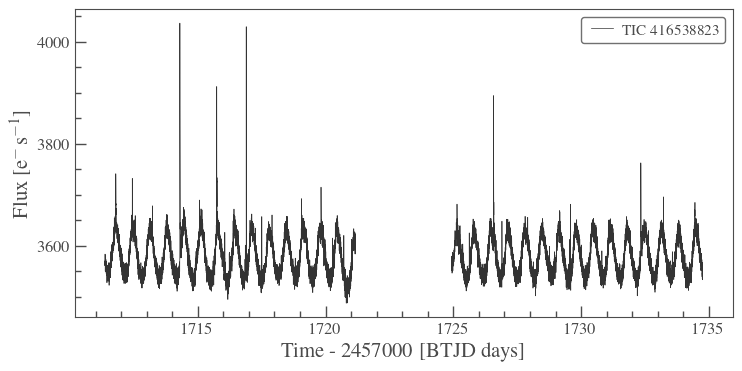

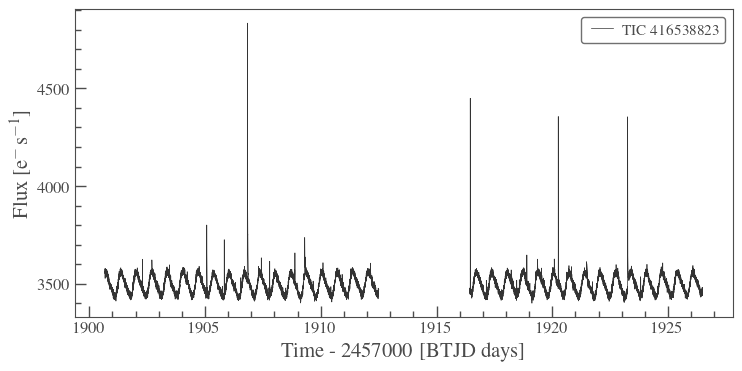

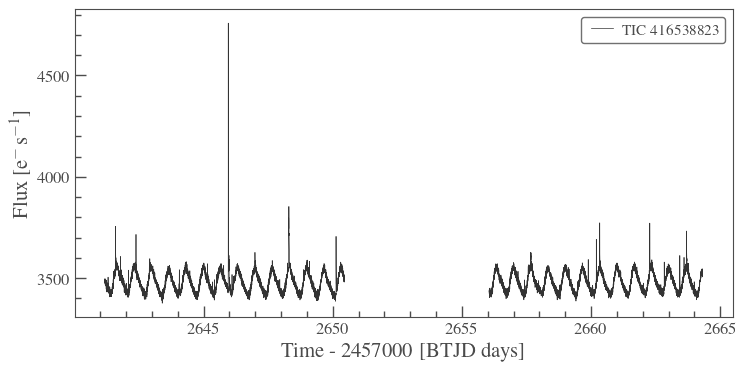

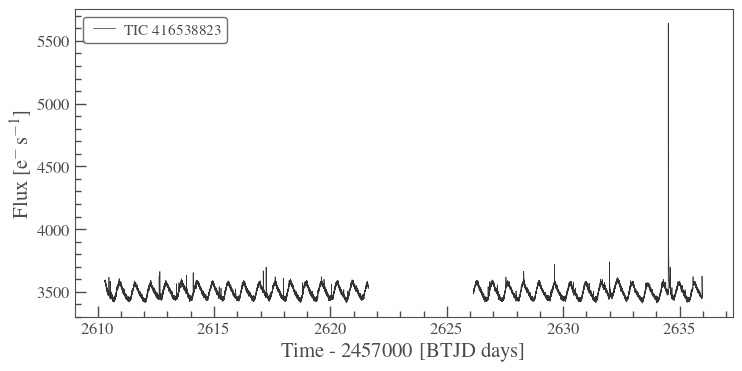

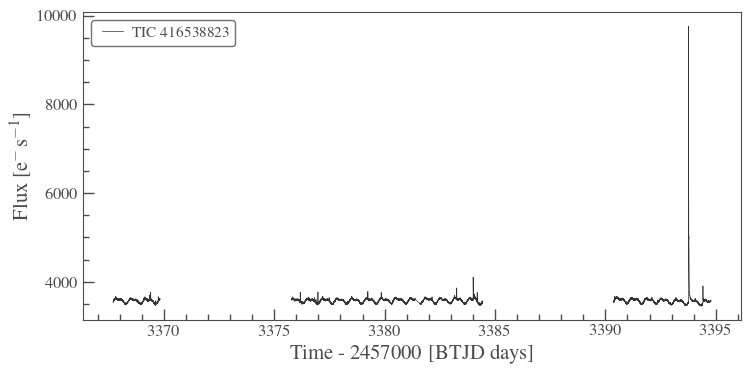

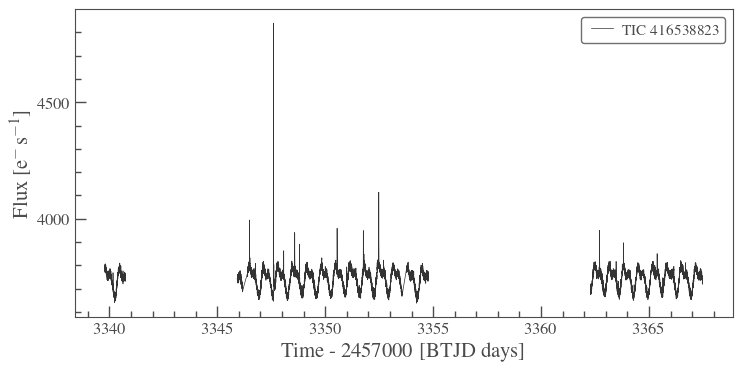

In [3]:
#[0, 3, 10, 14]
lc120s = []
for i, sr in enumerate(search_result):
    if sr.exptime[0].value == 120 and sr.author[0] == 'SPOC':
        print(i)
        # lc120s.append(i)
        lc120s.append(sr)
#         print(sr./#[0])
        lc = sr.download(download_dir='mastDownload/')
        lc.plot()
print(lc120s)

In [4]:
mids = []
periods = []
for sr in lc120s:
    lc = sr.download(download_dir='mastDownload/')
    lcn = lc.normalize().flatten(10001).remove_outliers()
    # lcn.plot()
    pg = lcn.to_periodogram(method='ls',oversample_factor=10, minimum_period=4*u.min, maximum_period = 13*u.d)
    # pg.plot()
    mid = (max(lcn.time.value) + min(lcn.time.value))/2
    period = pg.period_at_max_power
    mids.append(mid)
    periods.append(period.value)


[0.6684953256775916, 0.6674705214680476, 0.6671627412609057, 0.6673255574948215, 0.6672102138526814, 0.6669207174465618]


<ErrorbarContainer object of 3 artists>

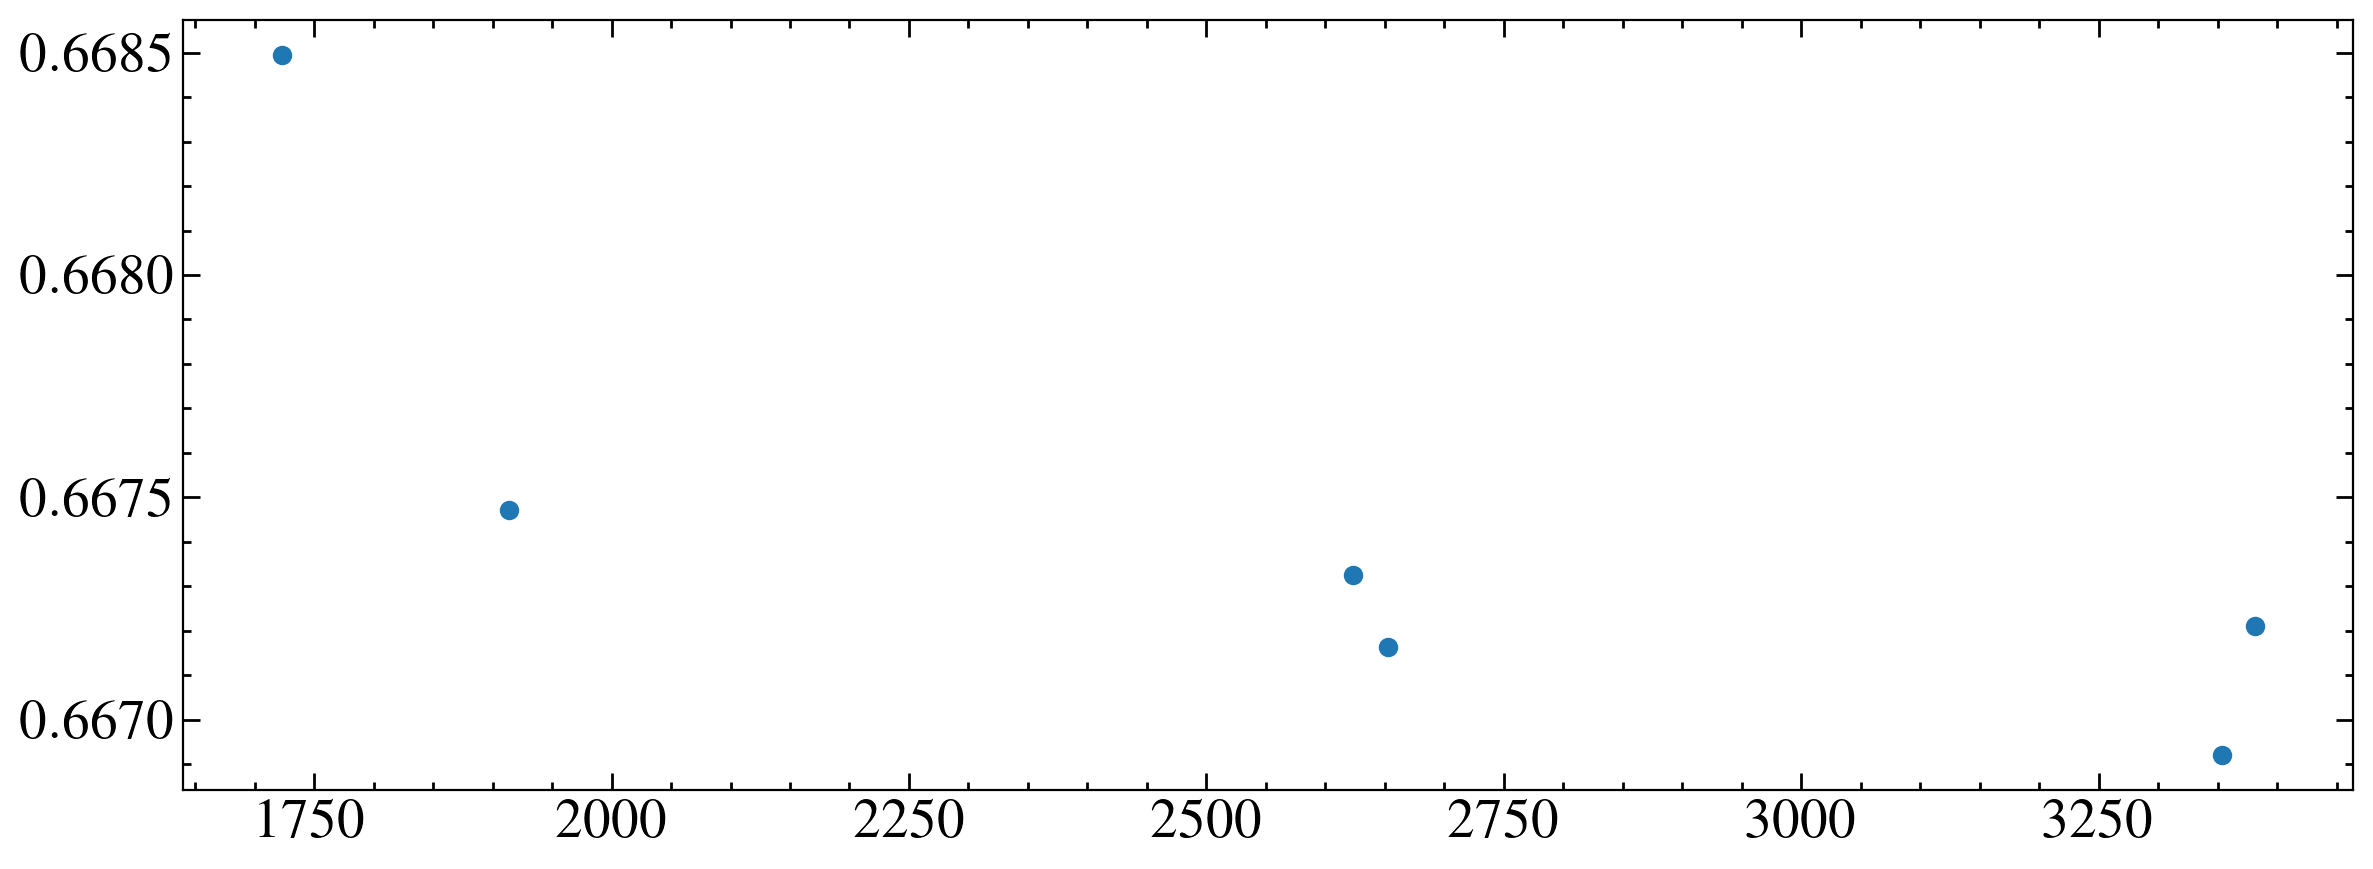

In [6]:
print(periods)
fig, ax = plt.subplots()
ax.errorbar(mids, periods, ls='none', marker='o')

In [7]:
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,SPOC,120,416538823,0.0
1,TESS Sector 22,2020,SPOC,120,416538823,0.0
2,TESS Sector 49,2022,SPOC,20,416538823,0.0
3,TESS Sector 48,2022,SPOC,20,416538823,0.0
4,TESS Sector 49,2022,SPOC,120,416538823,0.0
5,TESS Sector 48,2022,SPOC,120,416538823,0.0
6,TESS Sector 75,2024,SPOC,20,416538823,0.0
7,TESS Sector 76,2024,SPOC,20,416538823,0.0
8,TESS Sector 76,2024,SPOC,120,416538823,0.0


6
6
15
0.6676825685175208 d 16.0243816444205 h
0.6677127823027232 d 16.025106775265357 h 0.3337486551493195 d
22
0.6675826000242152 d 16.021982400581166 h
0.6675802680008156 d 16.021926432019576 h 0.3337525805071186 d
48
0.6676933241099021 d 16.02463977863765 h
0.6676989844103803 d 16.024775625849127 h 0.33382055981136916 d
49
0.6672105937964709 d 16.0130542511153 h
0.667223781232318 d 16.013370749575632 h 0.3338895506759412 d
75
0.6675839757756045 d 16.022015418614508 h
0.6675720830169497 d 16.021729992406794 h 0.3336941514881421 d
76
0.6674977405319944 d 16.019945772767866 h
0.6674250019632639 d 16.018200047118334 h 0.33370024150963973 d


<ErrorbarContainer object of 3 artists>

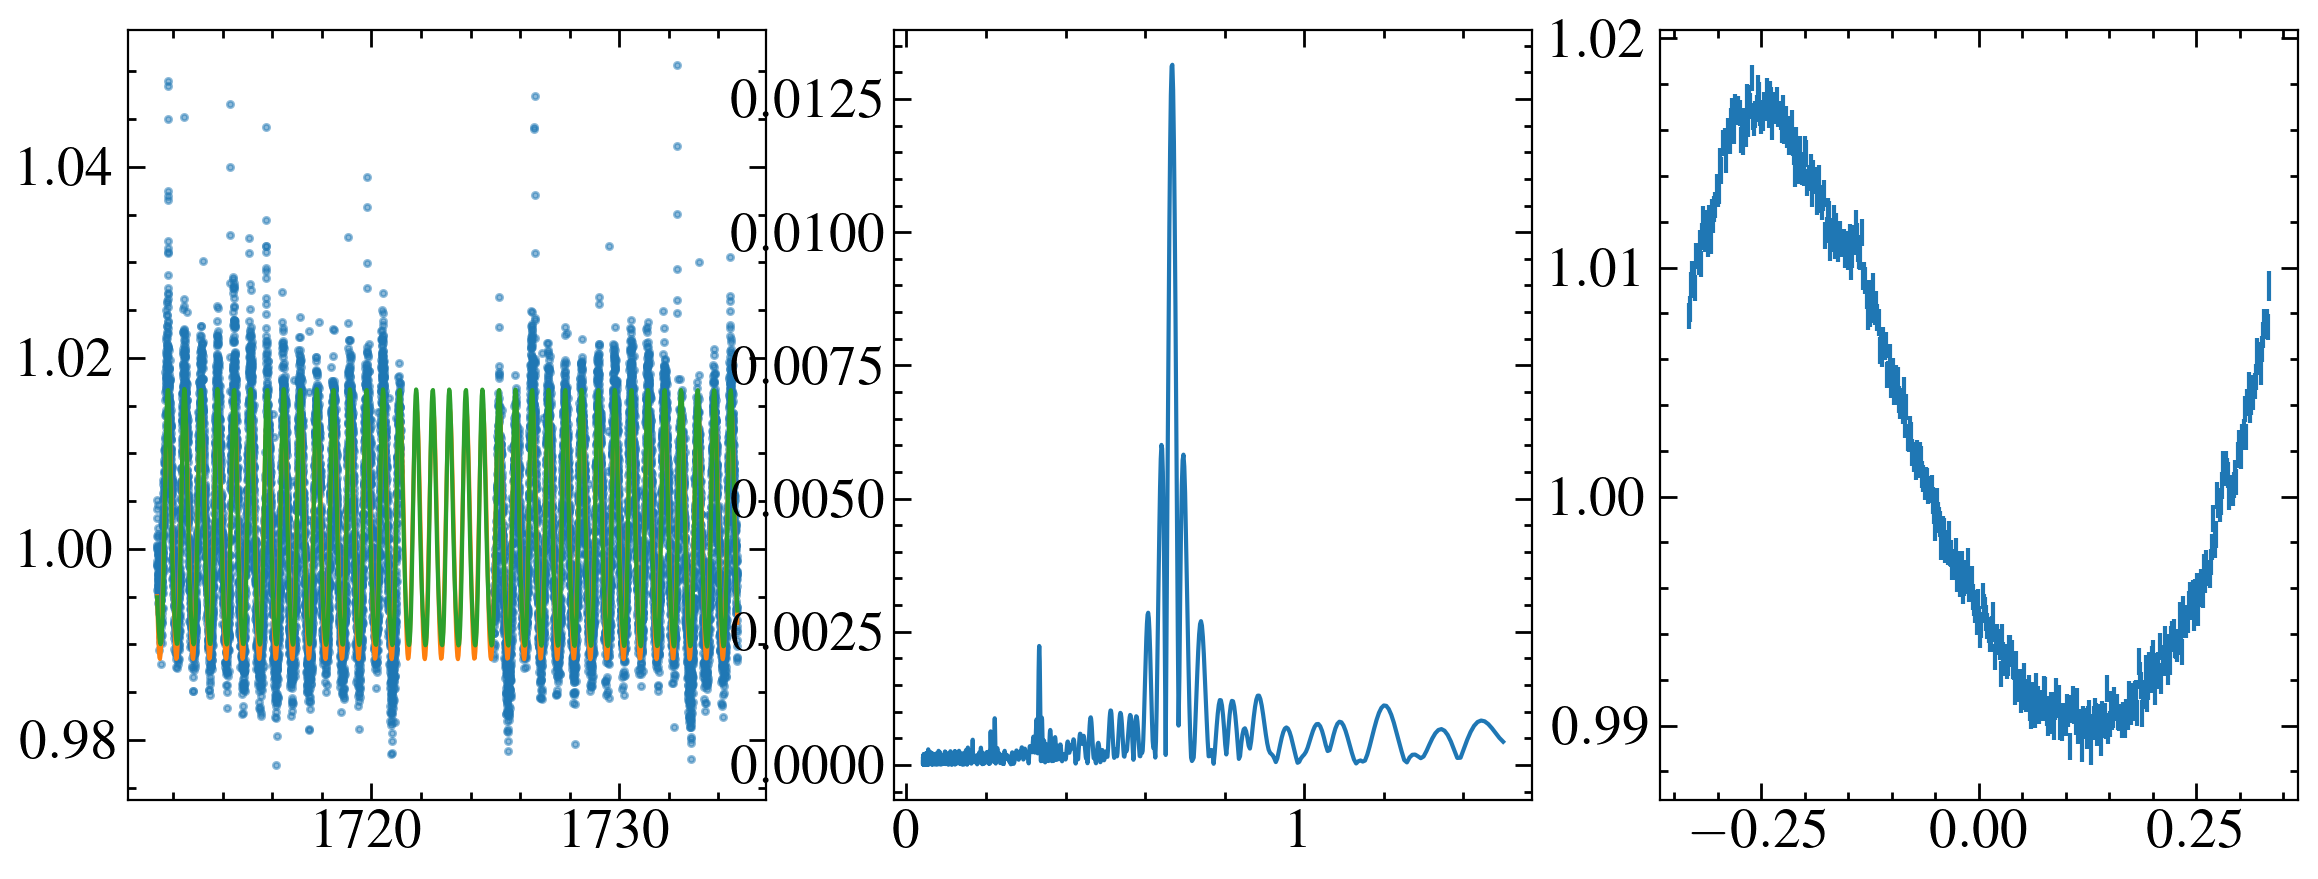

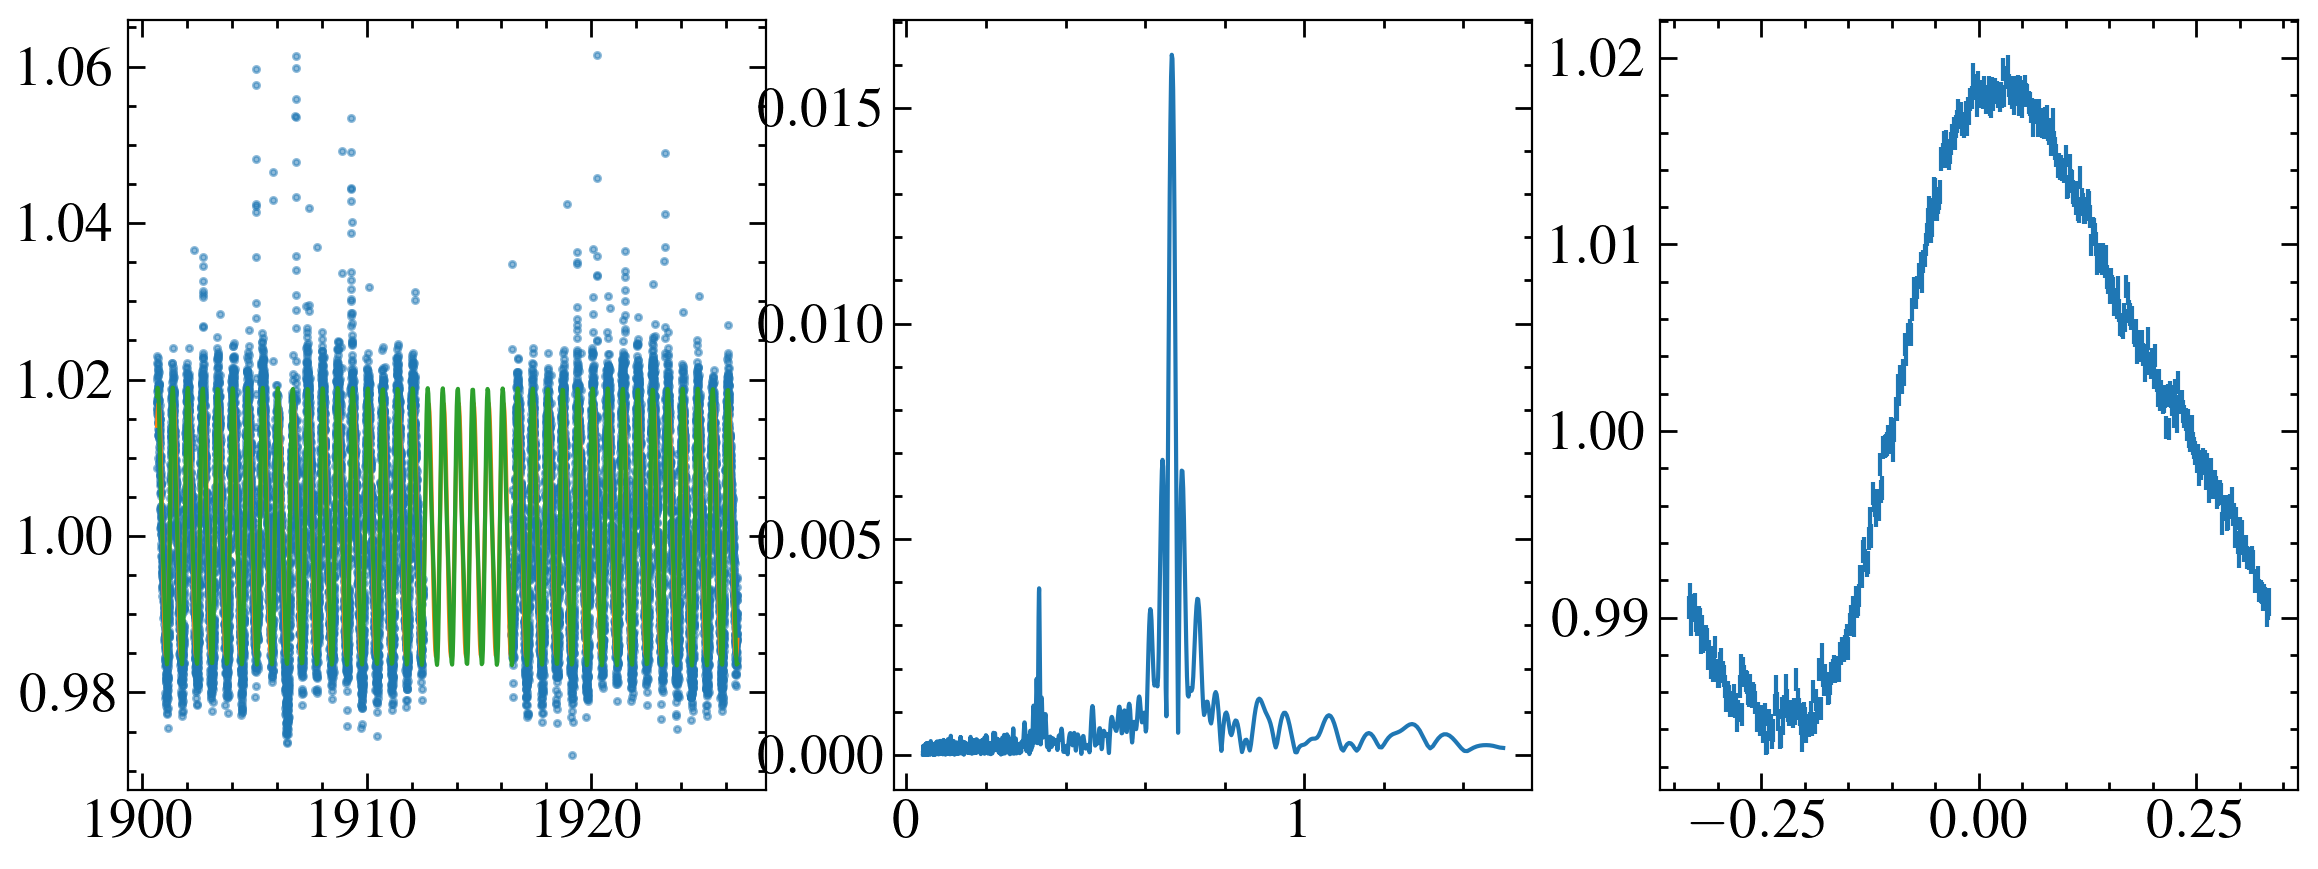

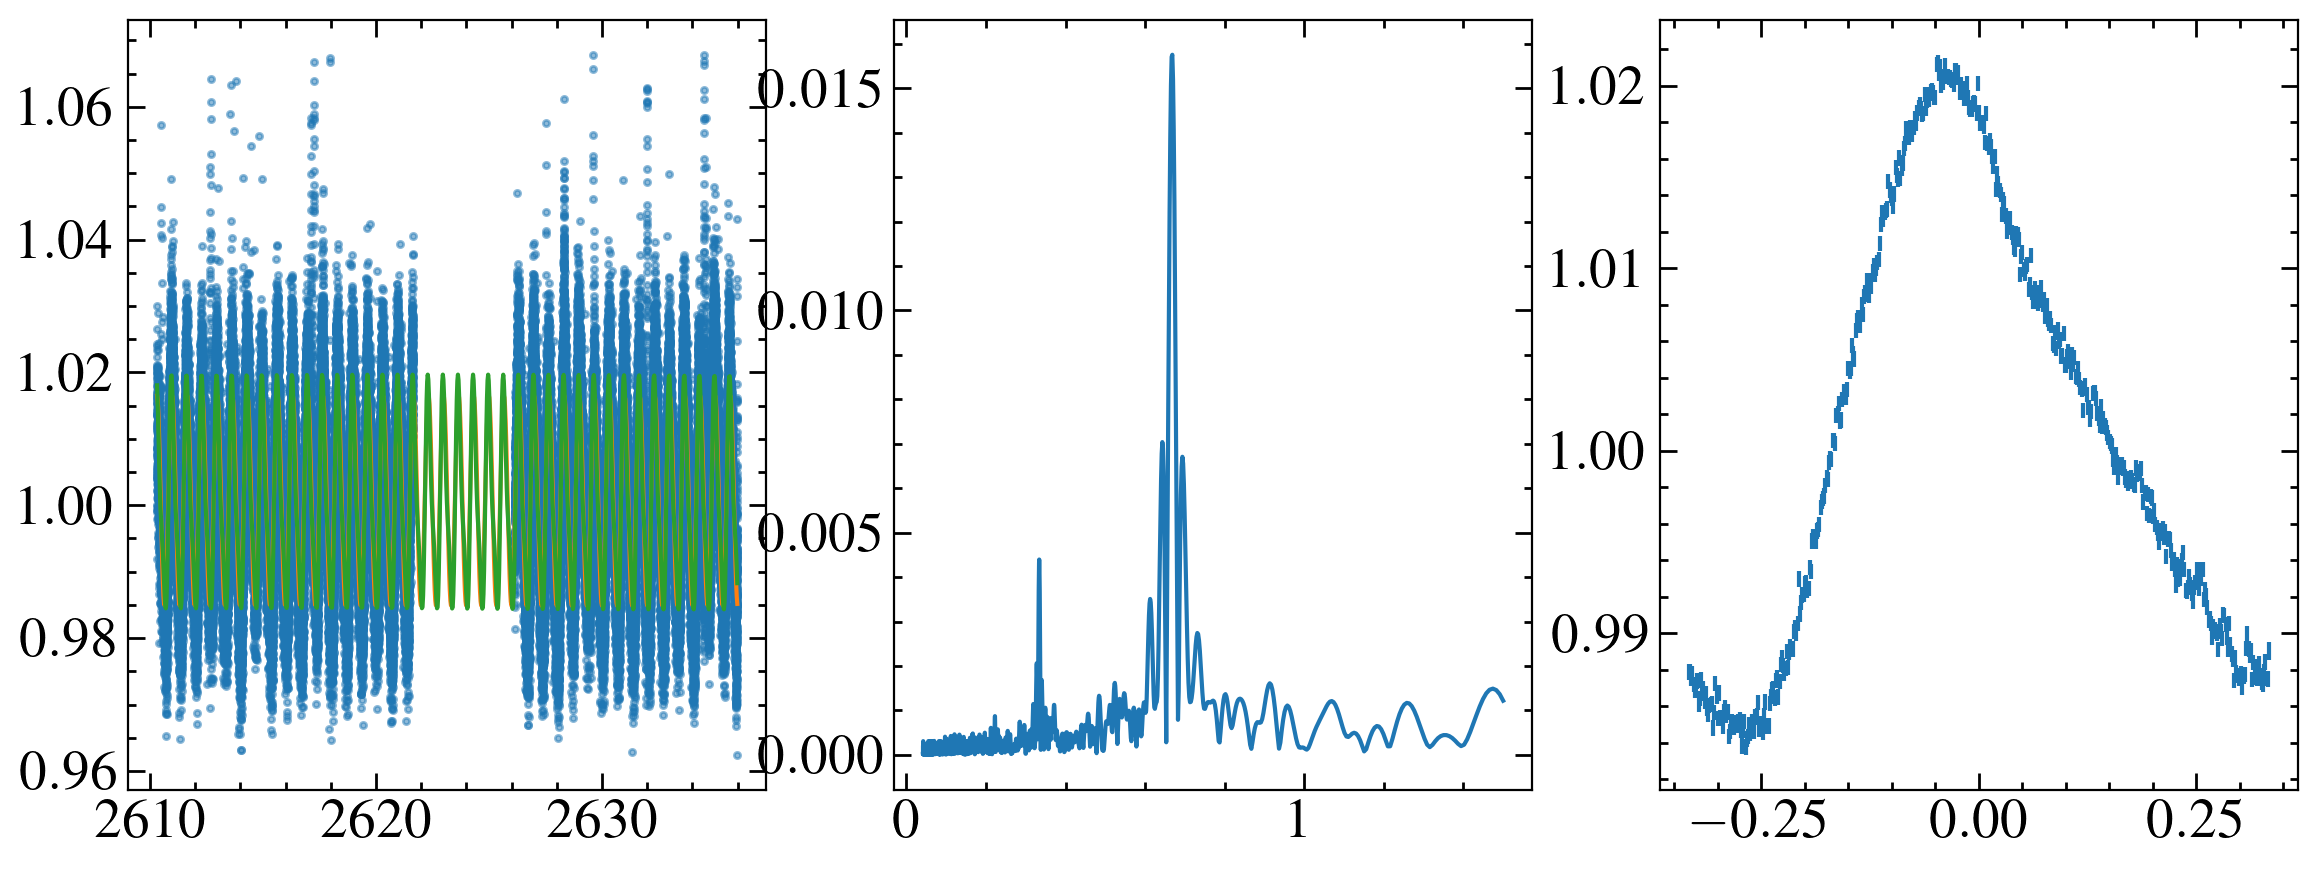

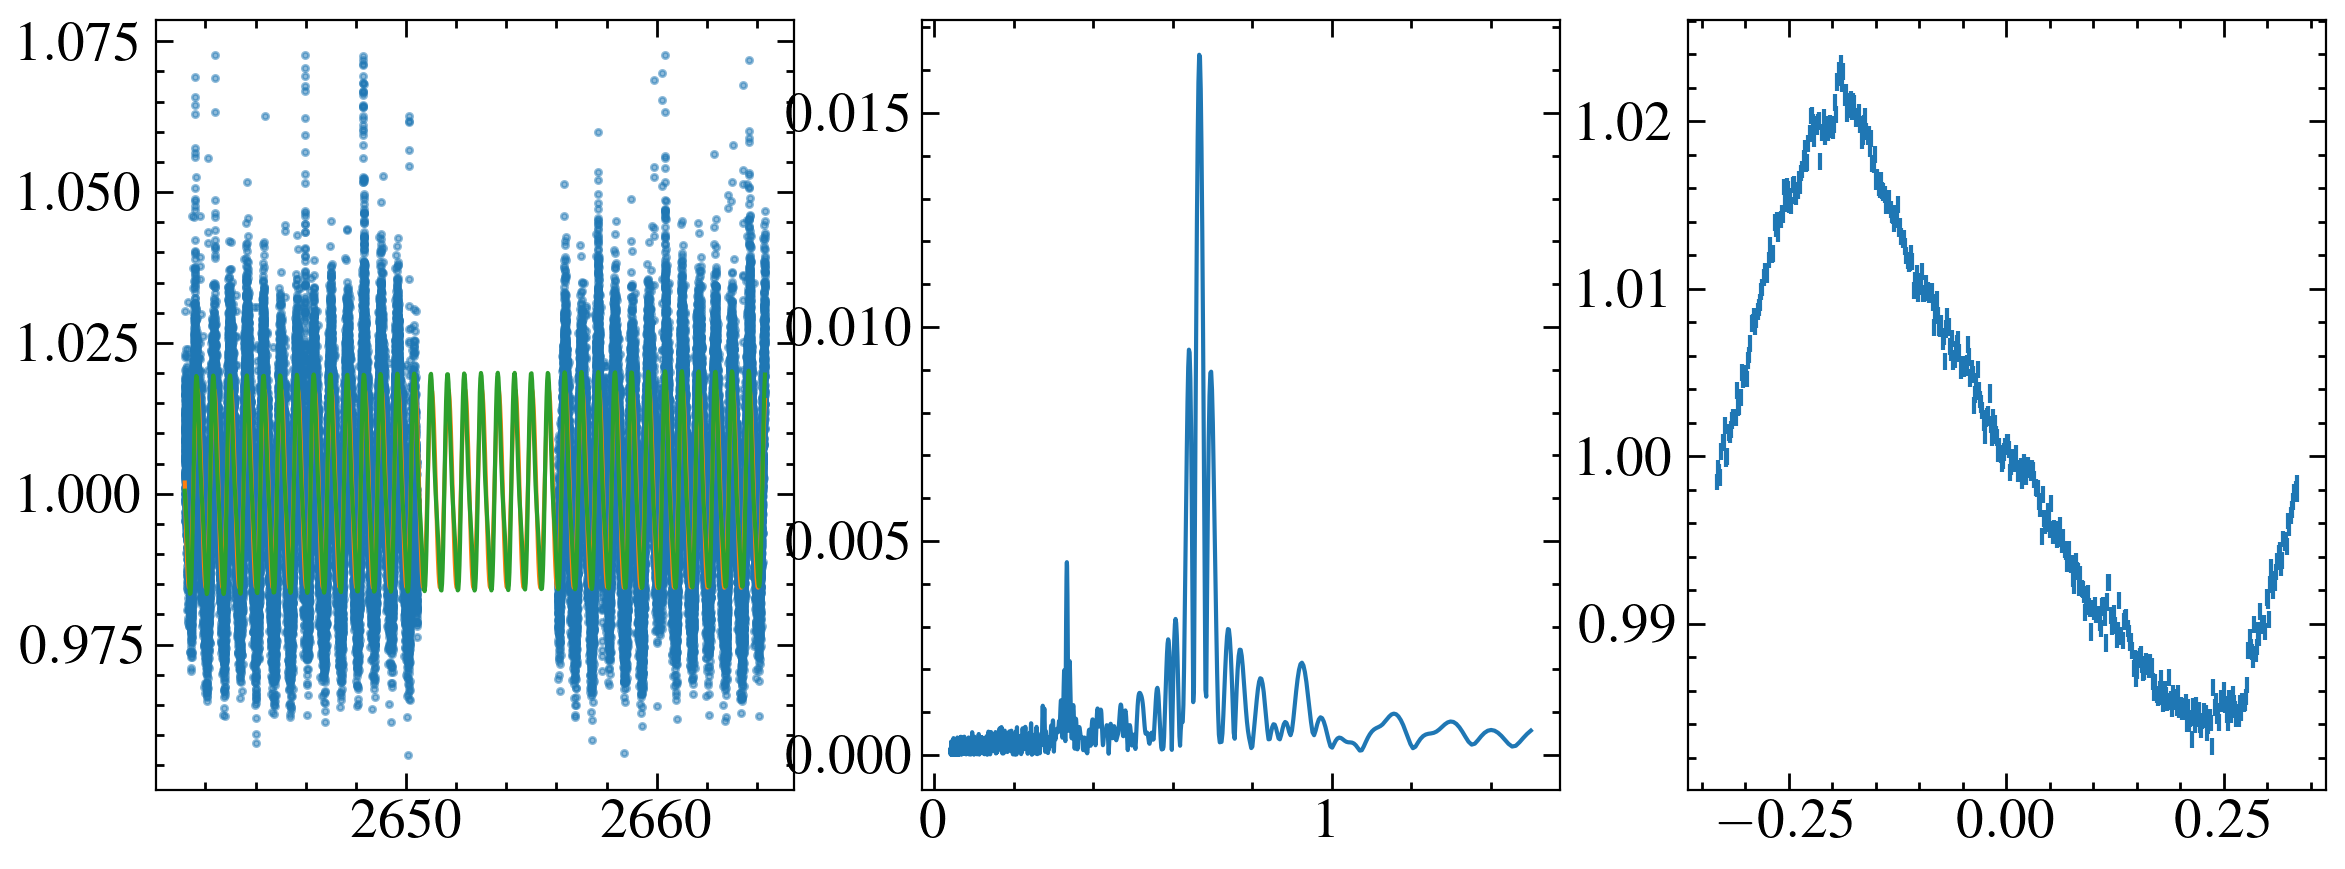

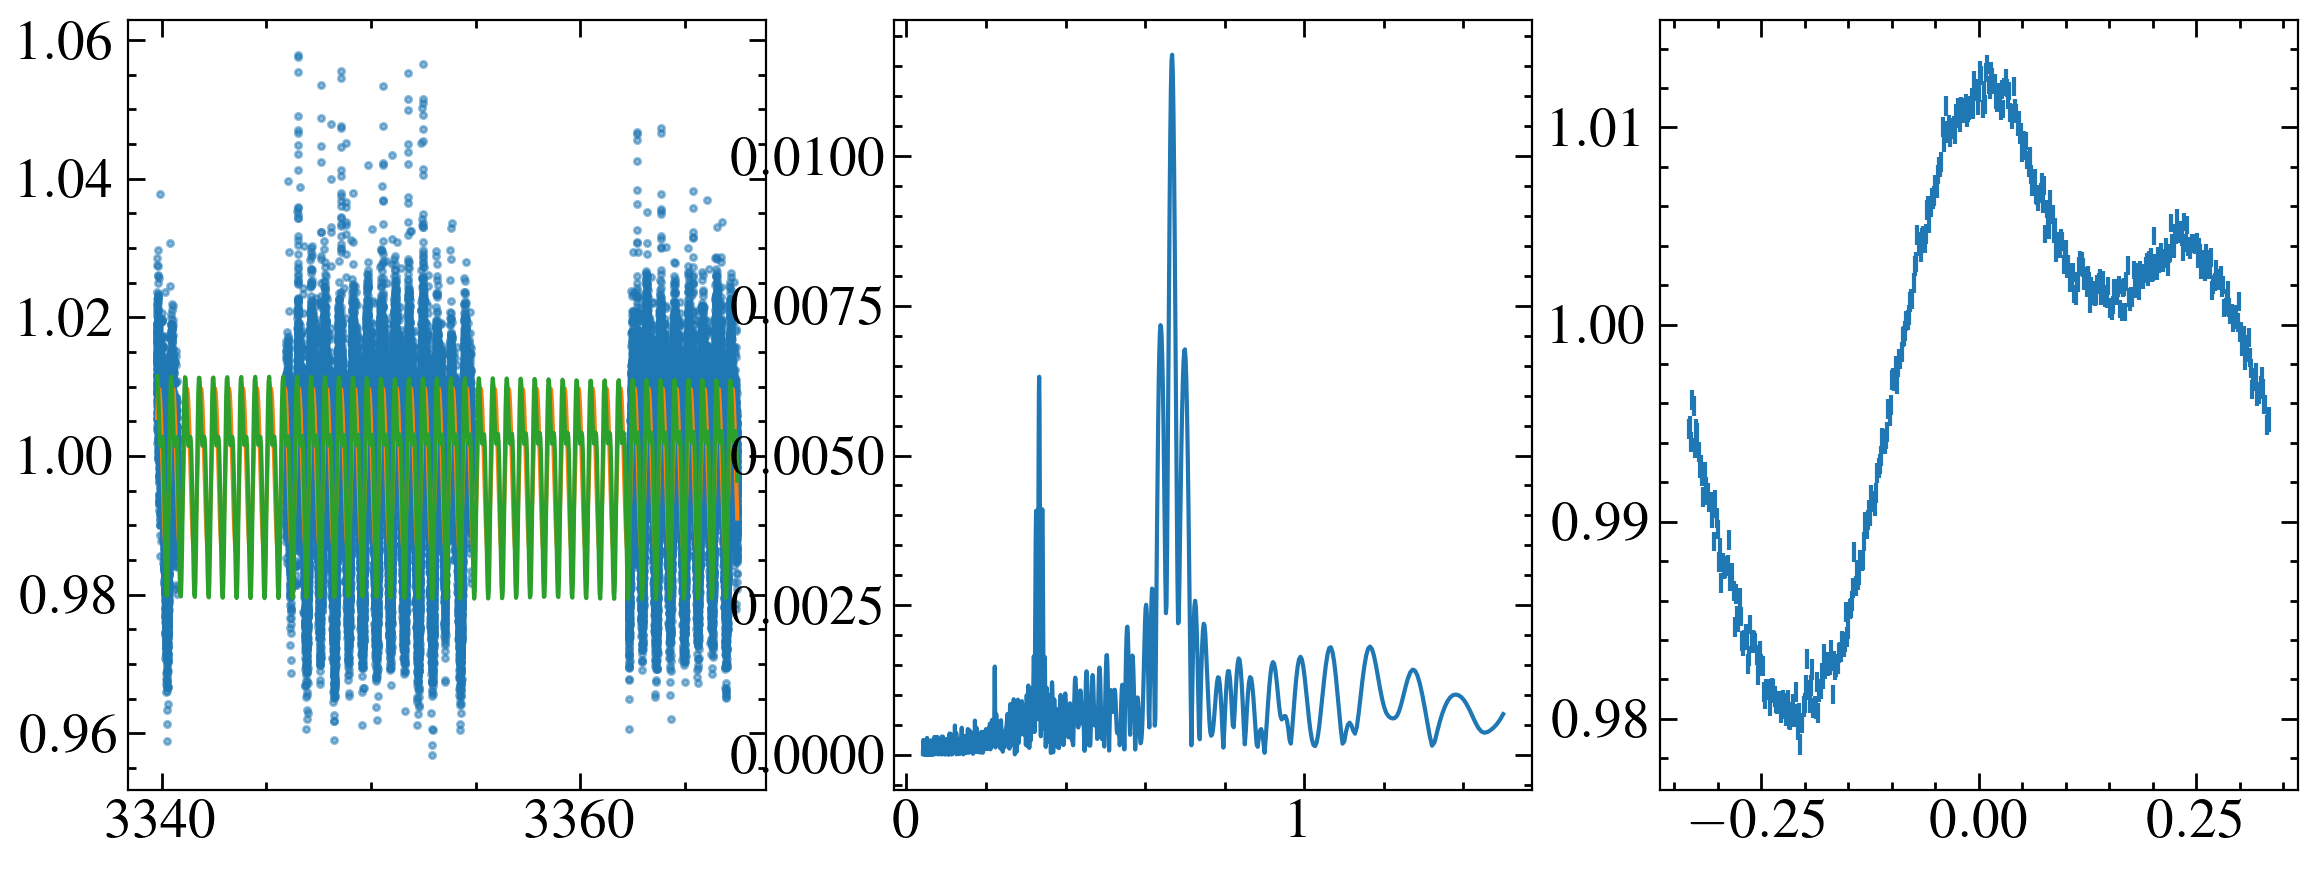

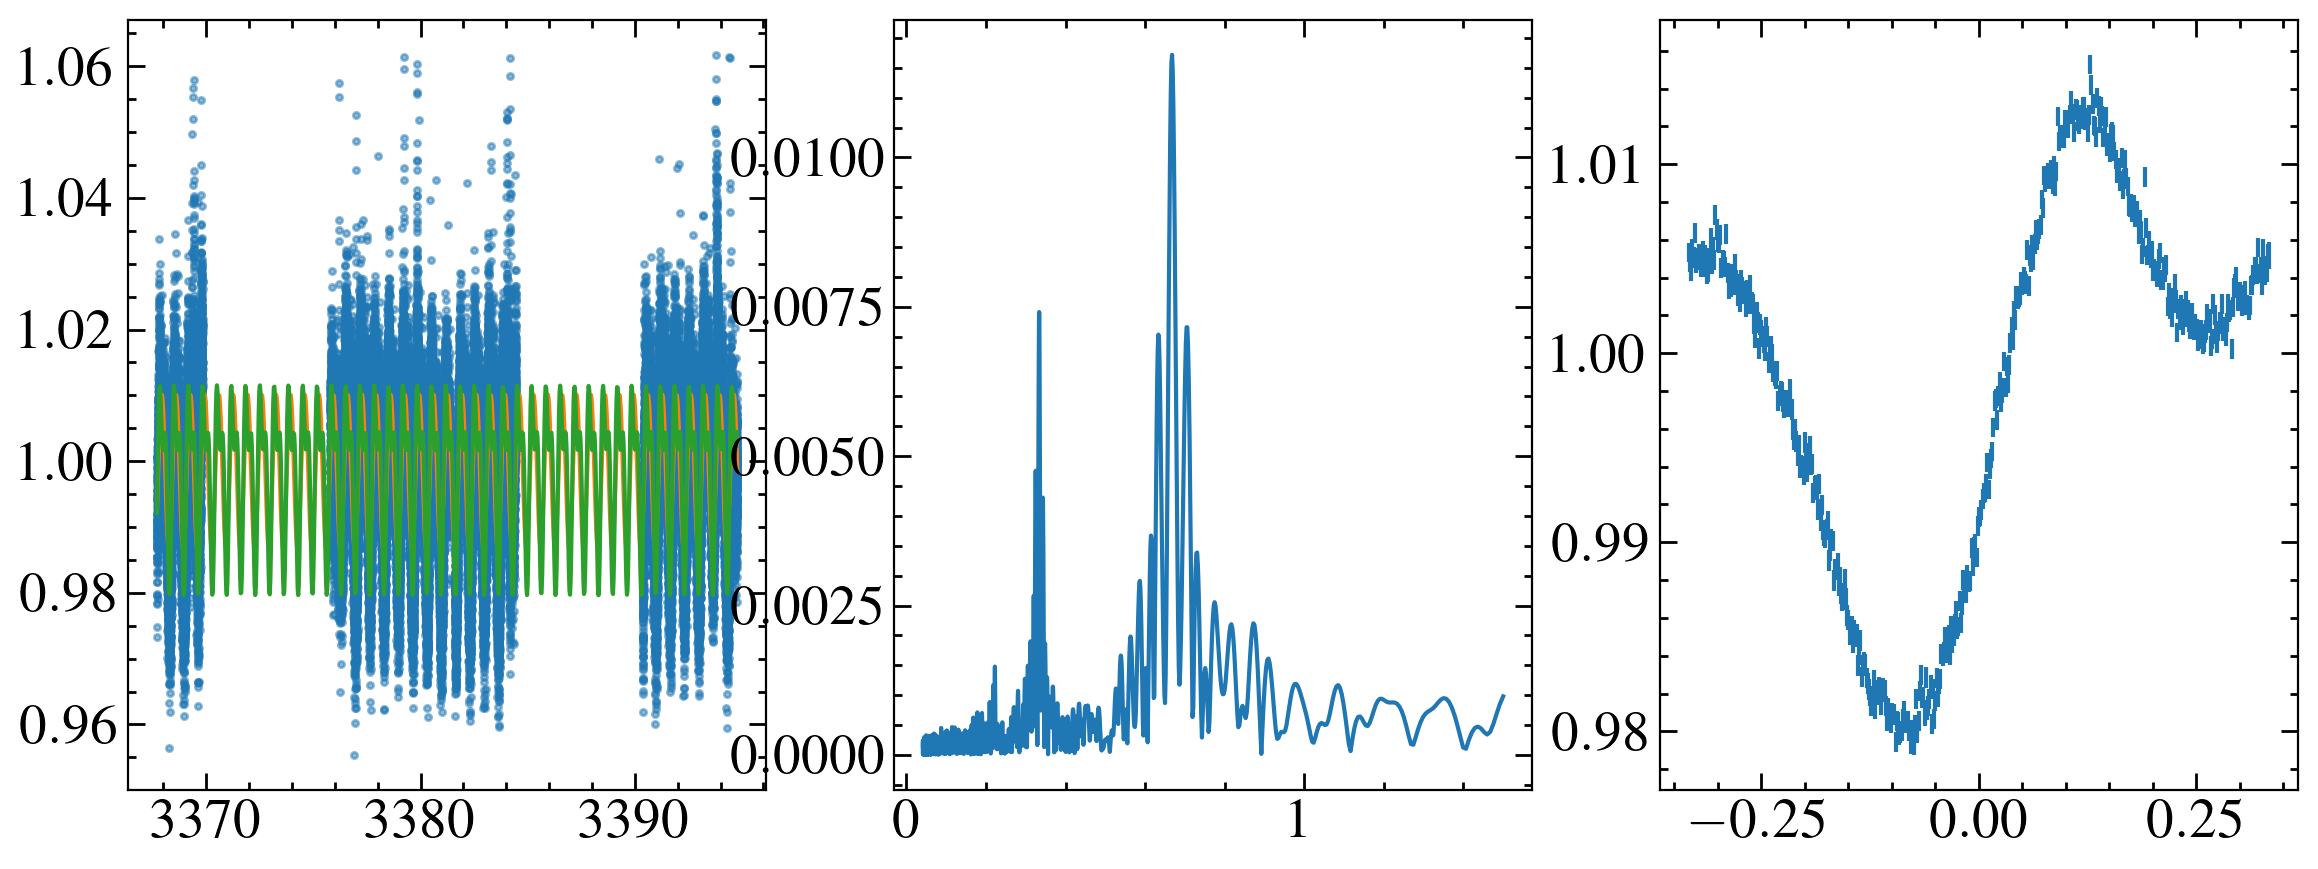

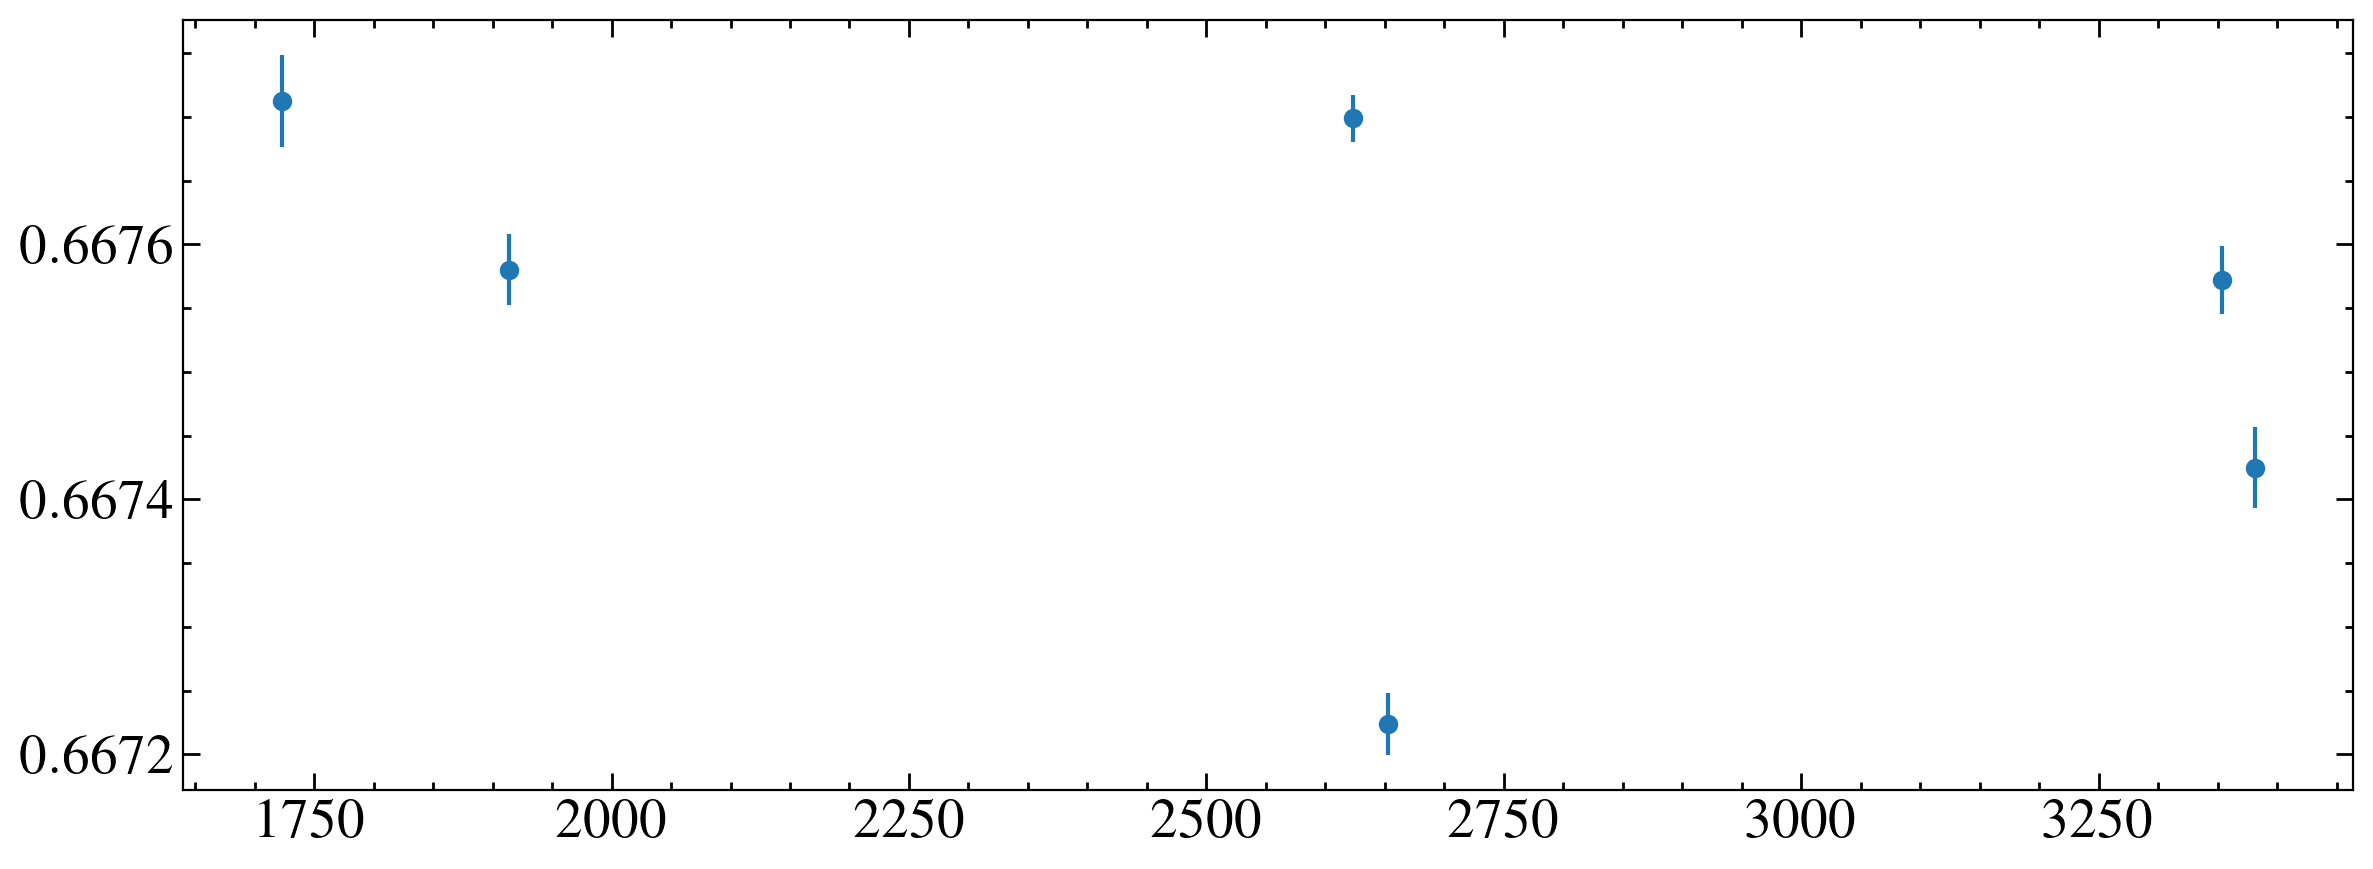

In [59]:
fitter =  fitting.LevMarLSQFitter(calc_uncertainties=True)


sectors = np.unique(np.array([m[-2:] for m in search_result.mission]))
mids = []
periods = []
period_errs = []


use_lcs = []
for sector in sectors:
    mask = (search_result.mission == 'TESS Sector {}'.format(sector)) & (search_result.author=='SPOC')
    sector_lcs = search_result[mask]
    c20 = False
    for lc in sector_lcs:
        if lc.exptime == 20*u.s:
            use_lcs.append(lc)
            c20=True
    if not c20:
          for lc in sector_lcs:
                if lc.exptime == 120*u.s:
                    use_lcs.append(lc)
  
print(len(sectors))
print(len(use_lcs))
# print(use_lcs)
for i, sr in enumerate(use_lcs):
    fig, axes = plt.subplots(ncols = 3)
    print(sectors[i])
    
    lc = sr.download(download_dir='mastDownload/')
    # lc.plot()
    lcn = lc.flatten(10001).normalize().remove_outliers(sigma=5)
    axes[0].scatter(lcn.time.value, lcn.flux, s=5, alpha=0.5, rasterized=True)
    # lcn.plot();
    pg = lcn.to_periodogram(method='ls',oversample_factor=10, minimum_period=1*u.hour, maximum_period = 1.5*u.d)
    # pg.plot();
    axes[1].plot(pg.period, pg.power)
    period_guess = pg.period_at_max_power
    # axes[1].axvline(period.value, ls='--', c='C2', alpha=0.5)
    # axes[1].axvline(period.value/2, ls='--', c='C2', alpha=0.5)

    mod1 = models.Sine1D(pg.max_power, 1/period_guess.value, 0) + models.Const1D(1)
    mod1_fit = fitter(mod1, lcn.time.value, lcn.flux.value)
    tplot= np.linspace(lcn.time[0].value, lcn.time[-1].value, 1000)
    axes[0].plot(tplot, mod1_fit(tplot), c='C1')
    # print(period, period.to(u.hr))
    period1 = (1/mod1_fit[0].frequency)*u.d
    print(period1, period1.to(u.hr))

    #try to fit the half period
    pg2 = lcn.to_periodogram(method='ls',oversample_factor=10, minimum_period=1*u.hour, maximum_period = 0.5*u.d)
    
    mod2 = models.Sine1D(pg.max_power, 1/period_guess.value, 0) + models.Sine1D(pg2.max_power, 2/period_guess.value, 0.5) + models.Const1D(1)
    mod2_fit = fitter(mod2, lcn.time.value, lcn.flux.value)
    # tplot= np.linspace(lcn.time[0].value, lcn.time[-1].value, 1000)
    axes[0].plot(tplot, mod2_fit(tplot), c='C2')
    # print(period, period.to(u.hr))
    period2 = (1/mod2_fit[0].frequency)*u.d
    print(period2, period2.to(u.hr), (1/mod2_fit[1].frequency)*u.d)

 


    lcf = lcn.fold(period2).bin(2*u.min)
    axes[2].errorbar(lcf.time.value, lcf.flux, yerr=lcf.flux_err, ls='none')

    periods.append(period2.value)
    period2_e = mod2_fit.stds['frequency_0']/(mod2_fit[0].frequency**2)
    period_errs.append(period2_e)

    mid = (max(lcn.time.value) + min(lcn.time.value))/2

    mids.append(mid)
    
fig, ax = plt.subplots()
ax.errorbar(mids, periods, yerr=period_errs, ls='none', marker='o')

# print(lc120s)

In [57]:
mod2_fit.stds['frequency_0']

7.097755811089773e-05